4 Rastgele Eğitim örnekleri ve etiketleri


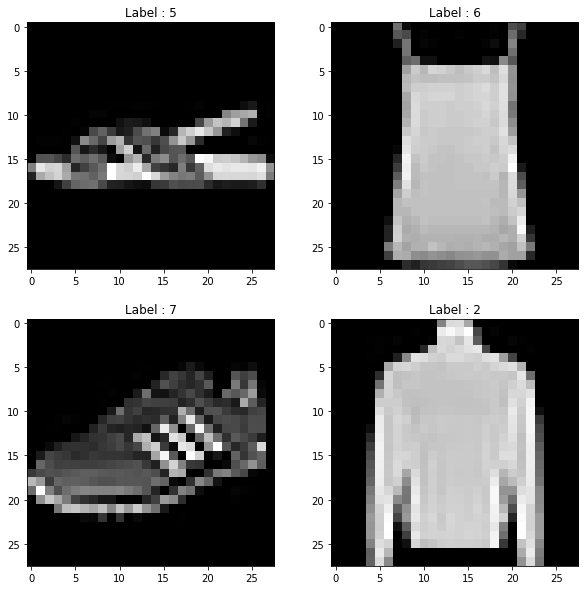

Epoch 1/150
Eğitim katmanı 1 şimdi : 
Eğitim katmanı 2 şimdi : 
Eğitim katmanı 1 şimdi : 
Eğitim katmanı 2 şimdi : 
1/1 [==============================] - 68s 68s/step - FinalLoss: 0.7233
Epoch 2/150
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.7060
Epoch 3/150
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.6880
Epoch 4/150
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.6710
Epoch 5/150
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.6560
Epoch 6/150
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.6432
Epoch 7/150
1/1 [==============================] - 6s 6s/step - FinalLoss: 0.6320
Epoch 8/150
1/1 [==============================] - 5s 5s/step - FinalLoss: 0.6222
Epoch 9/150
1/1 [==============================] - 5s 5s/step - FinalLoss: 0.6134
Epoch 10/150
1/1 [==============================] - 5s 5s/step - FinalLoss: 0.6053
Epoch 11/150
1/1 [==============================] - 6s 6s/step - FinalLos

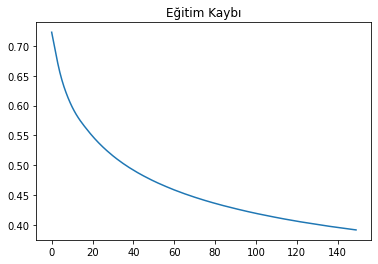

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import random
from tensorflow.compiler.tf2xla.python import xla

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data() # 28x28 
print("4 Rastgele Eğitim örnekleri ve etiketleri") # 4 adet rastgele eğitim örneği ve etiketleri
idx1, idx2, idx3, idx4 = random.sample(range(0, x_train.shape[0]), 4) # 4 adet rastgele eğitim örneği ve etiketleri

img1 = (x_train[idx1], y_train[idx1]) # 4 adet rastgele eğitim örneği ve etiketleri
img2 = (x_train[idx2], y_train[idx2]) # 4 adet rastgele eğitim örneği ve etiketleri
img3 = (x_train[idx3], y_train[idx3]) # 4 adet rastgele eğitim örneği ve etiketleri
img4 = (x_train[idx4], y_train[idx4]) # 4 adet rastgele eğitim örneği ve etiketleri

imgs = [img1, img2, img3, img4] # 4 adet rastgele eğitim örneği ve etiketleri

plt.figure(figsize=(10, 10)) # ekran boyutu

for idx, item in enumerate(imgs): # 4 adet rastgele eğitim örneği ve etiketleri
    image, label = item[0], item[1] # 4 adet rastgele eğitim örneği ve etiketleri
    plt.subplot(2, 2, idx + 1)
    plt.imshow(image, cmap="gray")
    plt.title(f"Label : {label}")
plt.show()

# Bu katman FF Network ile birlikte kullanılacaktır.
class FFDense(keras.layers.Layer): # FFDense sınıfı
    def __init__( # __init__ fonksiyonu
        self, 
        units,
        optimizer,
        loss_metric,
        num_epochs=50,
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.dense = keras.layers.Dense(
            units=units,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
        )
        self.relu = keras.layers.ReLU()
        self.optimizer = optimizer
        self.loss_metric = loss_metric
        self.threshold = 1.5
        self.num_epochs = num_epochs

    # girdiyi dense katmanına vermeden önce normalize ediyoruz.
    def call(self, x):
        x_norm = tf.norm(x, ord=2, axis=1, keepdims=True)
        x_norm = x_norm + 1e-4
        x_dir = x / x_norm
        res = self.dense(x_dir)
        return self.relu(res)


    # Forward-Forward algoritması aşağıdadır. 
    # Önce Dense katmanı işlemi gerçekleştiriyoruz ve ardından pozitif ve negatif örnekler için ortalama kare değerini alıyoruz.
    # Özel kayıp fonksiyonu, ortalama kare sonucu ve ayarladığımız eşik değeri arasındaki mesafeyi bulur (hiperparametre olarak tanımlanmıştır).
    # Bu, tahminin pozitif veya negatif doğası olup olmadığını tanımlamak için ayarlanan eşik değerinden ne kadar uzak olduğunu belirler.
    # Kayıp hesaplandıktan sonra, tüm yığını bir arada toplayarak bir ortalama alır ve bir gradyan hesaplama ve optimizasyon adımı gerçekleştirir.
    # Bu, gerçekten geri yayılımı nitelendirmiyor çünkü önceki katmana herhangi bir gradyan gönderilmiyor ve tamamen yerel bir doğa sahiptir.
    def forward_forward(self, x_pos, x_neg):
        for i in range(self.num_epochs):
            with tf.GradientTape() as tape:
                g_pos = tf.math.reduce_mean(tf.math.pow(self.call(x_pos), 2), 1)
                g_neg = tf.math.reduce_mean(tf.math.pow(self.call(x_neg), 2), 1)

                loss = tf.math.log(
                    1
                    + tf.math.exp(
                        tf.concat([-g_pos + self.threshold, g_neg - self.threshold], 0)
                    )
                )
                mean_loss = tf.cast(tf.math.reduce_mean(loss), tf.float32)
                self.loss_metric.update_state([mean_loss])
            gradients = tape.gradient(mean_loss, self.dense.trainable_weights)
            self.optimizer.apply_gradients(zip(gradients, self.dense.trainable_weights))
        return (
            tf.stop_gradient(self.call(x_pos)),
            tf.stop_gradient(self.call(x_neg)),
            self.loss_metric.result(),
        )
    
class FFNetwork(keras.Model):
    """
    Bu model her türlü sınıflandırma görevi için çalışabilir. 
    """
    
    # Her katman gradyan hesaplamasını ve optimizasyonunu yerel olarak çalıştırdığından, her katmanın geçirdiğimiz kendi optimize edicisi vardır.
    # Standart bir seçim olarak, deneyden sonra en iyi oran olduğu tespit edildiğinden, varsayılan öğrenme oranı 0,03 olan `Adam` optimize ediciyi geçiyoruz.
    # Kayıp, `loss_var` ve `loss_count` değişkenleri kullanılarak izlenir.
    def __init__(
        self, dims, layer_optimizer=keras.optimizers.Adam(learning_rate=0.03), **kwargs
    ):
        super().__init__(**kwargs)
        self.layer_optimizer = layer_optimizer
        self.loss_var = tf.Variable(0.0, trainable=False, dtype=tf.float32)
        self.loss_count = tf.Variable(0.0, trainable=False, dtype=tf.float32)
        self.layer_list = [keras.Input(shape=(dims[0],))]
        for d in range(len(dims) - 1):
            self.layer_list += [
                FFDense(
                    dims[d + 1],
                    optimizer=self.layer_optimizer,
                    loss_metric=keras.metrics.Mean(),
                )
            ]


    # Bu fonksiyon, etiketleri orijinal görüntünün üzerine yerleştiren dinamik bir değişiklik yapar
    # (bu örnekte, MNIST'in 10 benzersiz etiketi olduğundan, ilk 10 pikselin üst sol köşesini alıyoruz).
    # Bu fonksiyon, etiketlerin piksel tabanlı bir bir-hot temsilini oluşturan ilk 10 pikseli içeren orijinal veri tensörünü döndürür.
    @tf.function(reduce_retracing=True)
    def overlay_y_on_x(self, data):
        X_sample, y_sample = data
        max_sample = tf.reduce_max(X_sample, axis=0, keepdims=True)
        max_sample = tf.cast(max_sample, dtype=tf.float64)
        X_zeros = tf.zeros([10], dtype=tf.float64)
        X_update = xla.dynamic_update_slice(X_zeros, max_sample, [y_sample])
        X_sample = xla.dynamic_update_slice(X_sample, X_update, [0])
        return X_sample, y_sample


    # Bu özel `predict_one_sample`, görüntüleri ağa geçirerek tahminlerde bulunur, her katman tarafından üretilen sonuçları ölçer 
    # (yani, her etiket için ayarlanmış eşik değerine göre çıktı değerlerinin ne kadar yüksek/düşük olduğunu) ve ardından yalnızca en 
    # yüksek değerlere sahip etiketi bulur.
    # Bu tür bir durumda, görüntülerin tüm etiketlerle 'iyilik' test edilir.
    @tf.function(reduce_retracing=True)
    def predict_one_sample(self, x):
        goodness_per_label = [] # goodness_per_label, her etiket için bir ölçüm değeri içeren bir liste
        x = tf.reshape(x, [tf.shape(x)[0] * tf.shape(x)[1]]) # x, görüntüyü piksel tabanlı bir tensör haline getirir
        for label in range(10): # 10 etiket için döngü
            h, label = self.overlay_y_on_x(data=(x, label)) # etiketleri görüntünün üzerine yerleştirir
            h = tf.reshape(h, [-1, tf.shape(h)[0]]) # h, görüntüyü piksel tabanlı bir tensör haline getirir
            goodness = [] # goodness, her katman için bir ölçüm değeri içeren bir liste
            for layer_idx in range(1, len(self.layer_list)): # her katman için döngü
                layer = self.layer_list[layer_idx] # katmanı alır
                h = layer(h) # katmanı çalıştırır
                goodness += [tf.math.reduce_mean(tf.math.pow(h, 2), 1)] 
            goodness_per_label += [
                tf.expand_dims(tf.reduce_sum(goodness, keepdims=True), 1) # her etiket için bir ölçüm değeri
            ]
        goodness_per_label = tf.concat(goodness_per_label, 1)
        return tf.cast(tf.argmax(goodness_per_label, 1), tf.float64)

    def predict(self, data):
        x = data
        preds = list()
        preds = tf.map_fn(fn=self.predict_one_sample, elems=x)
        return np.asarray(preds, dtype=int)


    # Bu özel `train_step` işlevi dahili `train_step` uygulamasını geçersiz kılar. Tüm giriş görüntü tensörlerini alır,
    # onları düzleştirir ve ardından görüntüler üzerinde pozitif ve negatif örnekler üretir.
    # Pozitif örnek, `overlay_y_on_x` işleviyle etiket kodlanmış olan görüntüdür. Negatif örnek, yanlış etiketin bulunduğu bir görüntüdür.
    # Örnekler hazır olduğunda, her bir `FFLayer`'a geçirir ve onları Forward-Forward hesaplaması yapar. Döndürülen kayıp, tüm katmanlarda
    # son kayıp değeridir.
    @tf.function(jit_compile=True)
    def train_step(self, data):
        x, y = data

        # Flatten
        x = tf.reshape(x, [-1, tf.shape(x)[1] * tf.shape(x)[2]])

        x_pos, y = tf.map_fn(fn=self.overlay_y_on_x, elems=(x, y))

        random_y = tf.random.shuffle(y)
        x_neg, y = tf.map_fn(fn=self.overlay_y_on_x, elems=(x, random_y))

        h_pos, h_neg = x_pos, x_neg

        for idx, layer in enumerate(self.layers):
            if isinstance(layer, FFDense):
                print(f"Eğitim katmanı {idx+1} şimdi : ")
                h_pos, h_neg, loss = layer.forward_forward(h_pos, h_neg)
                self.loss_var.assign_add(loss)
                self.loss_count.assign_add(1.0)
            else:
                print(f"Geçen katman {idx+1} şimdi : ")
                x = layer(x)
        mean_res = tf.math.divide(self.loss_var, self.loss_count)
        return {"FinalLoss": mean_res}
    

x_train = x_train.astype(float) / 255
x_test = x_test.astype(float) / 255
y_train = y_train.astype(int)
y_test = y_test.astype(int)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_dataset = train_dataset.batch(60000)
test_dataset = test_dataset.batch(10000)

model = FFNetwork(dims=[784, 500, 500])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.03),
    loss="mse",
    jit_compile=True,
    metrics=[keras.metrics.Mean()],
)

epochs = 150
history = model.fit(train_dataset, epochs=epochs)

preds = model.predict(tf.convert_to_tensor(x_test))

preds = preds.reshape((preds.shape[0], preds.shape[1]))

results = accuracy_score(preds, y_test)

print(f"Test Doğruluk Puanı : {results*100}%")

plt.plot(range(len(history.history["FinalLoss"])), history.history["FinalLoss"])
plt.title("Eğitim Kaybı")
plt.show()